### Data Understanding

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/movielens-20m-dataset/rating.csv
/kaggle/input/movielens-20m-dataset/link.csv
/kaggle/input/movielens-20m-dataset/genome_tags.csv
/kaggle/input/movielens-20m-dataset/genome_scores.csv
/kaggle/input/movielens-20m-dataset/tag.csv
/kaggle/input/movielens-20m-dataset/movie.csv


Dataset ini terdiri dari 6 file terpisah, tapi yang saya gunakan pada proyek ini hanya 2 file saja, yaitu movie.csv dan rating.csv.

### Loading Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model

In [3]:
movies = pd.read_csv('/kaggle/input/movielens-20m-dataset/movie.csv')
ratings = pd.read_csv('/kaggle/input/movielens-20m-dataset/rating.csv')

### Univariate Exploratory Data Analysis

movies: merupakan informasi mengenai film.  
ratings: merupakan rating film yang diberikan oleh user.

Movies

In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
print('Jumlah data film: ', len(movies['movieId'].unique()))

Jumlah data film:  27278


Jumlah genre film:  20


<AxesSubplot:>

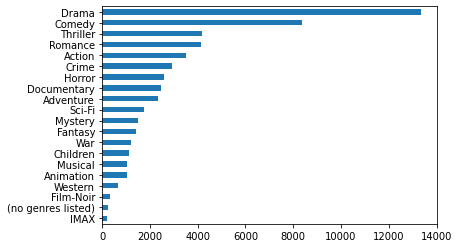

In [6]:
genres = movies['genres'].str.split('|').explode()

print('Jumlah genre film: ', len(genres.unique()))
genres.value_counts(ascending=True).plot(kind='barh')

Drama adalah genre film terbanyak, disusul oleh Comedy, Thriller, Romance, Action dan seterusnya.

Ratings

In [7]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [8]:
print('Jumlah user yang memberikan penilaian: ', len(ratings['userId'].unique()))
print('Jumlah film yang pernah dinilai user: ', len(ratings['movieId'].unique()))
print('Jumlah data penilaian film: ', len(ratings))

Jumlah user yang memberikan penilaian:  138493
Jumlah film yang pernah dinilai user:  26744
Jumlah data penilaian film:  20000263


In [9]:
ratings.describe().T

,count,mean,std,min,25%,50%,75%,max
userId,20000263.0,69045.872583,40038.626653,1.0,34395.0,69141.0,103637.0,138493.0
movieId,20000263.0,9041.567330,19789.477445,1.0,902.0,2167.0,4770.0,131262.0
rating,20000263.0,3.525529,1.051989,0.5,3.0,3.5,4.0,5.0


Nilai rating terendah adalah 0.5, sedangkan nilai rating tertinggi adalah 5.0. 

### Data Preprocessing

Menggabungkan dataframe movies dan ratings

In [10]:
df_fix = pd.merge(movies, ratings, on='movieId', how='left')
df_fix

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.0,4.0,1999-12-11 13:36:47
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,6.0,5.0,1997-03-13 17:50:52
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8.0,4.0,1996-06-05 13:37:51
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10.0,4.0,1999-11-25 02:44:47
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11.0,4.5,2009-01-02 01:13:41
...,...,...,...,...,...,...
20000792,131254,Kein Bund für's Leben (2007),Comedy,79570.0,4.0,2015-03-30 19:32:59
20000793,131256,"Feuer, Eis & Dosenbier (2002)",Comedy,79570.0,4.0,2015-03-30 19:48:08
20000794,131258,The Pirates (2014),Adventure,28906.0,2.5,2015-03-30 19:56:32
20000795,131260,Rentun Ruusu (2001),(no genres listed),65409.0,3.0,2015-03-30 19:57:46


### Data Preparation

Drop kolom timestamp karena tidak diperlukan

In [11]:
df_fix.drop('timestamp', axis=1, inplace=True)

Cek Missing Value

In [12]:
df_fix.isnull().sum()

movieId      0
title        0
genres       0
userId     534
rating     534
dtype: int64

Terdapat 534 baris missing value pada kolom userId dan rating. Karena jumlah ini tidak banyak dibandingkan dengan total data yang ada, data ini akan di-drop.

In [13]:
df_fix.dropna(inplace=True)

### Model Content Based Filtering

Membuat dataframe baru untuk data film yang terdiri dari id, title, dan genres.

In [14]:
movie_df = pd.DataFrame({
    'id': df_fix['movieId'].tolist(),
    'title': df_fix['title'].tolist(),
    'genres': df_fix['genres'].tolist()
})

Drop data film yang duplikat

In [15]:
movie_df = movie_df.drop_duplicates('id')
movie_df.head()

,id,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
49695,2,Jumanji (1995),Adventure|Children|Fantasy
71938,3,Grumpier Old Men (1995),Comedy|Romance
84673,4,Waiting to Exhale (1995),Comedy|Drama|Romance
87429,5,Father of the Bride Part II (1995),Comedy


Membuat matriks genre untuk setiap film

In [16]:
movie_df['genres'] = movie_df['genres'].str.split('|')

for index, data in movie_df.iterrows():
  for genre in data['genres']:
    movie_df.at[index, genre] = 1

movie_df = movie_df.fillna(0)
genres_matrix = movie_df.loc[:, 'Adventure':]
genres_matrix.head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49695,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71938,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84673,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87429,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Menghitung cosine similarity antar film

In [17]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(genres_matrix)
cosine_sim_df = pd.DataFrame(cosine_sim, index=movie_df['title'], columns=movie_df['title'])
cosine_sim_df.sample(5, axis=1).sample(5, axis=0)

title,Heaven Can Wait (1978),Black Magic (Meeting at Midnight) (Charlie Chan in Meeting at Midnight) (Charlie Chan in Black Magic) (1944),Marius and Jeanette (Marius et Jeannette) (1997),Strait-Jacket (1964),"Flintstones, The (1994)"
title,,,,,
Gaudi Afternoon (2001),0.57735,0.666667,0.666667,0.000000,0.333333
Yes (2004),0.00000,0.577350,0.577350,0.000000,0.000000
Filmistaan (2014),0.00000,0.000000,0.000000,0.000000,0.000000
Cargo (2006),0.00000,0.333333,0.333333,0.408248,0.000000
You Killed Me First (1985),0.00000,0.577350,0.577350,0.000000,0.000000


Mendapatkan rekomendasi film

In [18]:
def movie_recommender(movie_name, similarity_data=cosine_sim_df, items=movie_df[['title', 'genres']], k=20):
  index = similarity_data.loc[:, movie_name].to_numpy().argpartition(range(-1, -k, -1))
  closest = similarity_data.iloc[index[-1:-(k+2):-1]][movie_name]
  closest = closest.drop(movie_name, errors='ignore')
  return pd.DataFrame(closest).merge(items, on='title').head(k).rename({movie_name: 'cosine_sim'}, axis=1)

Film pertama

In [19]:
movie = 'Toy Story (1995)'
movie_df[movie_df['title'].eq(movie)].loc[:, :'genres']

,id,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"


In [20]:
movie_recommender(movie)

,title,cosine_sim,genres
0,DuckTales: The Movie - Treasure of the Lost La...,1.000000,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,"Monsters, Inc. (2001)",1.000000,"[Adventure, Animation, Children, Comedy, Fantasy]"
2,Aladdin (1992),1.000000,"[Adventure, Animation, Children, Comedy, Musical]"
3,Aladdin (1992),1.000000,"[Adventure, Animation, Children, Comedy, Fantasy]"
4,"Boxtrolls, The (2014)",1.000000,"[Adventure, Animation, Children, Comedy, Fantasy]"
5,"Wild, The (2006)",1.000000,"[Adventure, Animation, Children, Comedy, Fantasy]"
6,Turbo (2013),1.000000,"[Adventure, Animation, Children, Comedy, Fantasy]"
7,Shrek the Third (2007),1.000000,"[Adventure, Animation, Children, Comedy, Fantasy]"
8,Toy Story Toons: Hawaiian Vacation (2011),1.000000,"[Adventure, Animation, Children, Comedy, Fantasy]"
9,Toy Story Toons: Small Fry (2011),1.000000,"[Adventure, Animation, Children, Comedy, Fantasy]"


Model dapat memberikan rekomendasi yang sangat baik dengan nilai similarity diatas 0.9.

Film kedua

In [21]:
movie = '13Hrs (2010)'
movie_df[movie_df['title'].eq(movie)].loc[:, :'genres']

,id,title,genres
19587846,81451,13Hrs (2010),"[Adventure, Mystery]"


In [22]:
movie_recommender(movie)

,title,cosine_sim,genres
0,Sasquatch: The Legend of Bigfoot (1977),1.000000,"[Adventure, Mystery]"
1,Four Men and a Prayer (1938),1.000000,"[Adventure, Mystery]"
2,"Saragossa Manuscript, The (Rekopis znaleziony ...",0.816497,"[Adventure, Drama, Mystery]"
3,"Lone Ranger and the Lost City of Gold, The (1958)",0.816497,"[Adventure, Mystery, Western]"
4,Victor and the Secret of Crocodile Mansion (2012),0.816497,"[Adventure, Children, Mystery]"
5,"Pink Panther 2, The (2009)",0.816497,"[Adventure, Comedy, Mystery]"
6,"Most Dangerous Game, The (1932)",0.816497,"[Adventure, Mystery, Thriller]"
7,Brand Upon the Brain! (2006),0.816497,"[Adventure, Fantasy, Mystery]"
8,"Final Inquiry, The (Inquiry, The) (inchiesta, ...",0.816497,"[Adventure, Drama, Mystery]"
9,Equinox (1970),0.816497,"[Adventure, Horror, Mystery]"


Model dapat memberikan rekomendasi yang cukup baik dengan nilai silimarity diatas 0.7. Nilai ini lebih rendah dari nilai rekomendasi untuk film pertama. Hal ini dapat disebabkan karena data yang tidak seimbang.

### Model Collaborative Filtering

Shuffling data

In [23]:
df_fix = df_fix.sample(frac=1, random_state=42)
df_fix

,movieId,title,genres,userId,rating
17679789,26283,Charley Varrick (1973),Crime|Drama|Thriller,2261.0,1.5
7106385,1271,Fried Green Tomatoes (1991),Comedy|Crime|Drama,2511.0,3.5
12970708,3328,Ghost Dog: The Way of the Samurai (1999),Crime|Drama,35449.0,3.0
15426752,5064,The Count of Monte Cristo (2002),Action|Adventure|Drama|Romance|Thriller,83679.0,4.0
6934678,1258,"Shining, The (1980)",Horror,91631.0,3.5
...,...,...,...,...,...
9628519,2059,"Parent Trap, The (1998)",Children|Comedy|Romance,100159.0,3.0
14586186,4306,Shrek (2001),Adventure|Animation|Children|Comedy|Fantasy|Ro...,54271.0,4.0
2234489,329,Star Trek: Generations (1994),Adventure|Drama|Sci-Fi,95544.0,3.0
13315092,3527,Predator (1987),Action|Sci-Fi|Thriller,15682.0,5.0


Encoding data user

In [24]:
user_ids = df_fix['userId'].unique().tolist()
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
df_fix['user'] = df_fix['userId'].map(user_to_user_encoded)
num_users = len(user_to_user_encoded)

Encoding data film

In [25]:
movie_ids = df_fix['userId'].unique().tolist()
movie_to_movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded_to_movie = {i: x for i, x in enumerate(movie_ids)}
df_fix['movie'] = df_fix['movieId'].map(movie_to_movie_encoded)
num_movies = len(movie_to_movie_encoded)

Split data, 90% untuk training dan 10% untuk validation.

In [26]:
min_rating = min(df_fix['rating'])
max_rating = max(df_fix['rating'])

x = df_fix[['user', 'movie']].values
y = df_fix['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

train_size = int(0.9 * df_fix.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_size],
    x[train_size:],
    y[:train_size],
    y[train_size:]
)

train_inputs = [x_train[:, 0], x_train[:, 1]]
val_inputs = [x_val[:, 0], x_val[:, 1]]

Membuat arsitektur model

In [27]:
embedding_size = 64

user_input = keras.layers.Input(shape=(1))
user_embedding = keras.layers.Embedding(num_users, embedding_size)(user_input)

movie_input = keras.layers.Input(shape=(1))
movie_embedding = keras.layers.Embedding(num_movies, embedding_size)(movie_input)

mod = keras.layers.Dot(2)([user_embedding, movie_embedding])
mod = keras.layers.Flatten()(mod)
mod = keras.layers.Activation('sigmoid')(mod)

model = Model(inputs=[user_input, movie_input], outputs=mod)

2022-08-15 07:09:36.454240: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Training model

In [28]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

history = model.fit(x=train_inputs, 
                    y=y_train, 
                    validation_data=(val_inputs, y_val),
                    batch_size=1000, 
                    epochs=3, 
                    verbose=1)

2022-08-15 07:11:09.288358: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/3
18001/18001 [==============================] - 2051s 114ms/step - loss: 0.5961 - root_mean_squared_error: 0.1978 - val_loss: 0.5790 - val_root_mean_squared_error: 0.1781
Epoch 2/3
18001/18001 [==============================] - 2048s 114ms/step - loss: 0.5707 - root_mean_squared_error: 0.1686 - val_loss: 0.5745 - val_root_mean_squared_error: 0.1731
Epoch 3/3
18001/18001 [==============================] - 2109s 117ms/step - loss: 0.5598 - root_mean_squared_error: 0.1557 - val_loss: 0.5760 - val_root_mean_squared_error: 0.1748


Dari proses training selama 3 epochs, diperoleh nilai error 0.1557, dan 0.1748 untuk data validasi.

Visualisasi metrik

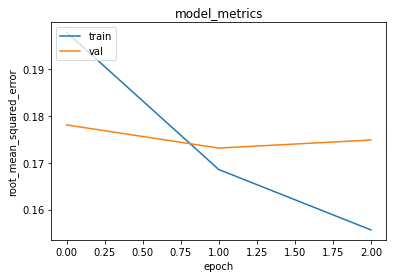

In [29]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Mendapatkan rekomendasi film

In [30]:
user_id = df_fix['user'].sample(1).iloc[0]
movie_watched_by_user = df_fix[df_fix['user'] == user_id]

movie_not_watched = df_fix[~df_fix['movie'].isin(movie_watched_by_user['movie'].values)]['movie'] 
movie_not_watched = list(set(movie_not_watched))
movie_not_watched = [[x] for x in movie_not_watched]

user_movie_array = np.hstack(([[user_id]] * len(movie_not_watched), movie_not_watched))
user_movie_array = [user_movie_array[:, 0], user_movie_array[:, 1]]

Film yang pernah ditonton user

In [31]:
print('UserId: {}'.format(user_id))
movie_watched_by_user.sort_values(by='rating', ascending=False).head(10)[['title', 'genres', 'rating']]

UserId: 17759


,title,genres,rating
2030105,Quiz Show (1994),Drama,5.0
4939412,"Godfather, The (1972)",Crime|Drama,5.0
6251534,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure,5.0
5032812,Rear Window (1954),Mystery|Thriller,5.0
628842,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,5.0
10254985,"Producers, The (1968)",Comedy,5.0
9569988,Saving Private Ryan (1998),Action|Drama|War,5.0
6175616,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,5.0
6322105,12 Angry Men (1957),Drama,5.0
5099893,Casablanca (1942),Drama|Romance,5.0


Rekomendasi film untuk user

In [32]:
predict = model.predict(user_movie_array).flatten()

top_ratings_indices = predict.argsort()[-20:][::-1]
recommended_movie_ids = [
    movie_encoded_to_movie.get(movie_not_watched[x][0]) for x in top_ratings_indices
]

movie_df[movie_df['id'].isin(recommended_movie_ids)][['title', 'genres']]

,title,genres
4573591,Dr. Strangelove or: How I Learned to Stop Worr...,"[Comedy, War]"
4748668,"Gate of Heavenly Peace, The (1995)",[Documentary]
6675915,Annie Hall (1977),"[Comedy, Romance]"
17165357,Band of Brothers (2001),"[Action, Drama, War]"
17664075,"Burmese Harp, The (Biruma no tategoto) (1956)","[Drama, War]"
17665446,"Human Condition III, The (Ningen no joken III)...","[Drama, War]"
17667845,Crooks in Clover (a.k.a. Monsieur Gangster) (L...,"[Action, Comedy, Crime]"
17862268,"Trou, Le (Hole, The) (Night Watch, The) (1960)","[Crime, Film-Noir]"
18176991,Babylon 5,[Sci-Fi]
19169624,"Lonely Wife, The (Charulata) (1964)","[Drama, Romance]"
